# Warehouse Robot on a Slippery Floor

<a class="anchor" id="Toc"><a>
# Table of Content
1. [Install libraries](#install_libraries)
1. [Import libraries](#import_libraries)
1. [Create and Inspect](#create_and_inspect)
1. [Q-Learning Implementation](#q_learning_implementation)
1. [Training Q-Learning Agent](#q_learning_training)
1. [Evaluation](#evaluation)
1. [Optimization](#optimization)


<a class="anchor" id="install_libraries"></a>
# Install libraries

In [59]:
#pip install gymnasium pygame numpy matplotlib

<a class="anchor" id="import_libraries"></a>
# Import libraries

In [141]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import gymnasium as gym
from IPython.display import display, clear_output
import time
import networkx as nx
from gymnasium.envs.toy_text.frozen_lake import MAPS as FROZEN_LAKE_MAPS
import seaborn as sns
from tabulate import tabulate
import itertools

<a class='anchor' id='create_and_inspect'></a>
# Create and Inspect

In [73]:
# Initialize the environment
def get_env(env_name: str, map_name: str, is_slippery: bool, render_mode: str, max_episode_steps: int = 1000):
    env = gym.make(env_name, map_name=map_name, is_slippery=is_slippery, render_mode=render_mode, max_episode_steps=max_episode_steps)
    return env

env = get_env("FrozenLake-v1", "8x8", True, "ansi") # when slippery is True, the agent may not move in the intended direction add randomness to the environment

# basic info
env.reset()
print(env.render())
print("Action space size:", env.action_space.n)
print("Observation space size:", env.observation_space.n)


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Action space size: 4
Observation space size: 64


We are going to use the built inn reward system inn Gym's environment where:
- Move to a Frozen tile(F) give 0 reward
- Fall into a Hole(H) give 0 reward and end the episode
- Reaching the Goal(G) give reward 1 and end the episode

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

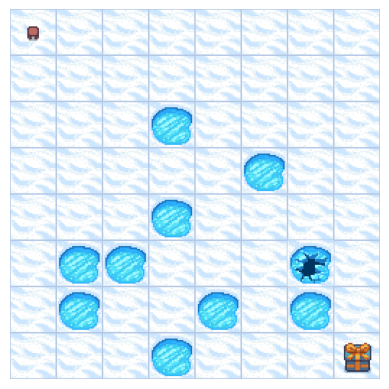

In [76]:
# Test and Visualize a random policy and heuristic policy
def run_random_episode(env, visualize=True, episodes=500):
    success_flags = []
    for episode in range(episodes):
        state, info = env.reset()
        done = False
        number_of_steps = 0
        while not done:
            action = env.action_space.sample()  # Take a random action
            state, reward, done, truncated, info = env.step(action)
            number_of_steps += 1
            success_flags.append(1 if done and reward == 1 else 0)
            if visualize:
                animation_speed = 0.1  # seconds between frames
                plt.ion()
                img = env.render()
                plt.imshow(img)
                plt.axis('off')
                clear_output(wait=True)
                display(plt.gcf())
                time.sleep(animation_speed)
                if done or number_of_steps >= 30:
                    clear_output(wait=False)
                    plt.ioff()
                    break
    return success_flags
        
    

def run_heuristic_episode(env, visualize=True, episodes=500):
    success_flags = []
    for episode in range(episodes):
        state, info = env.reset()
        done = False
        while not done:
            # Heuristic: Move right if possible, else move down
            row = state // int(np.sqrt(env.observation_space.n))
            col = state % int(np.sqrt(env.observation_space.n))

            if col < np.sqrt(env.observation_space.n) - 1:
                        action = 2  # right
            else:
                        action = 1  # down

            state, reward, done, truncated, info = env.step(int(action))
            success_flags.append(1 if done and reward == 1 else 0)
            if visualize:
                    animation_speed = 0.1  # seconds between frames
                    plt.ion()
                    img = env.render()
                    plt.imshow(img)
                    plt.axis('off')
                    clear_output(wait=True)
                    display(plt.gcf())
                    time.sleep(animation_speed)
                    if done:
                        clear_output(wait=False)
                        plt.ioff()
                        break
    return success_flags

env = get_env("FrozenLake-v1", "8x8", True, "rgb_array", max_episode_steps=500) # make it rgb_array for visualization
#run_random_episode(env, visualize=True, episodes=1)
run_heuristic_episode(env, visualize=True, episodes=1)

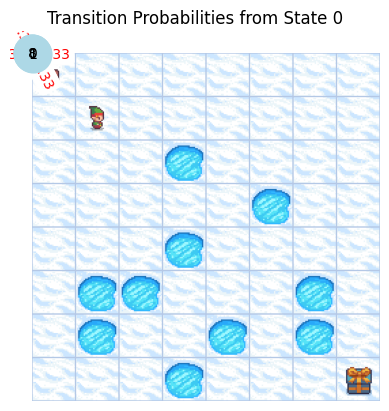

In [63]:
def inspect_transition_probabilities(env, state: int):
    env_raw = env.unwrapped
    G = nx.DiGraph()
    for action in range(env.action_space.n):
        transitions = env_raw.P[state][action]
        for prob, next_state, reward, done in transitions:
            if prob > 0:
                G.add_edge(state, next_state, action=action, weight=prob)
    pos = nx.spring_layout(G)
    edge_labels = {(u, v): f"a:{d['action']}, p:{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.title(f"Transition Probabilities from State {state}")
    plt.show()
inspect_transition_probabilities(env, state=0)

<a class="anchor" id="q_learning_implementation"></a>
# Q-Learning Implementation

In [64]:
# intialize the Q-table 
n_states = env.observation_space.n
n_actions = env.action_space.n

Q_table = np.zeros((n_states, n_actions))
print("Q table shape:")
print(Q_table.shape)

Q table shape:
(64, 4)


In [65]:
# define ε-greedy action policy
def epsilon_greedy_policy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # Explore: select a random action
    else:
        return np.argmax(Q[state])  # Exploit: select the action with max value (greedy)

In [93]:
def epsilon_decay_normal(initial_epsilon, min_epsilon, decay_rate): # epsilon decay function
    return max(min_epsilon, initial_epsilon * decay_rate)

### Q-Learning Update Rule

The Q-learning update rule is defined as:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]
$$

####  Variable Definitions

- \( Q(s, a) \): Estimated value of taking action \( a \) in state \( s \).
- \( \alpha \): Learning rate (how quickly the agent updates its knowledge).
- \( r \): Reward received after taking action \( a \) in state \( s \).
- \( \gamma \): Discount factor (how much future rewards are valued).
- \( \max_{a'} Q(s', a') \): Maximum estimated value of the next state \( s' \), over all possible actions \( a' \).
- \( s \): Current state.
- \( a \): Action taken in state \( s \).
- \( s' \): Next state after taking action \( a \).
- \( a' \): A possible action in the next state \( s' \).

In [66]:
def q_update(Q: np.ndarray, state: int, action: int, reward: float, next_state: int, alpha: float, gamma: float, done: bool):
    # target = r + γ max_a' Q(s', a')
    target = reward + gamma * np.max(Q[next_state])*(not done)
    Q[state][action] += alpha * (target - Q[state][action])

In [67]:
# run a single Q-learning episode
def run_q_learning_episode(env, Q, alpha, gamma, epsilon, visualize=True):
    state, info = env.reset()
    done = False
    total_reward = 0
    number_of_steps = 0

    while not done:
        action = epsilon_greedy_policy(Q, state, epsilon) # select action
        next_state, reward, done, truncated, info = env.step(action)
        number_of_steps += 1

        # perform Q-value update
        q_update(Q, state, action, reward, next_state, alpha, gamma, done)
        state = next_state
        total_reward += reward
        if visualize: # visualize the environment
            img = env.render()
            plt.imshow(img)
            plt.axis('off')
            clear_output(wait=True)
            display(plt.gcf())
            time.sleep(0.3)
            if done or number_of_steps >= 30:
                clear_output(wait=False)
                break

    print("Q-table after this episode:") # show first 5 states' action values
    print(Q[:5])
    return print("Total reward this episode:", total_reward)
run_q_learning_episode(env, Q_table, alpha=0.8, gamma=0.99, epsilon=0.1, visualize=True)

Q-table after this episode:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Total reward this episode: 0


<a class="anchor" id="q_learning_training"></a>
# Training Q-Learning Agent
Goal

- Run multiple episodes to train the agent:

- Use the ε-greedy policy from before.

- Add ε decay (less exploration over time).

- Update the Q-table after every step.

- Track episode returns and success rate


In [114]:
def q_learning_training(env: gym.Env, num_episodes: int, alpha: float, gamma: float, epsilon: float, epsilon_min: float, epsilon_decay: float, visualize: bool = False, epsilon_scheduling_type: str = 'normal'):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))
    epsilon_initial = epsilon
    
    # tracking variables
    rewards = [] # total rewards per episode
    success_flags = [] # 1 if goal reached, else 0

    for episode in range(num_episodes):
        state, info = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = epsilon_greedy_policy(Q, state, epsilon) # ε-greedy action selection
            # Take a step in the environment
            next_state, reward, done, truncated, info = env.step(action)
            # Q-value update
            q_update(Q, state, action, reward, next_state, alpha, gamma, done)
            state = next_state
            total_reward += reward
            # Visualization
            if visualize:
                env.render()
                img = env.render()
                plt.imshow(img) 
                plt.axis('off')
                clear_output(wait=True)
                display(plt.gcf())
                if done:
                    clear_output(wait=False)
        # record results
        rewards.append(total_reward)
        success_flags.append(1 if done and reward > 0 else 0)

        # Decay epsilon
        if epsilon_scheduling_type == 'normal':
            epsilon = epsilon_decay_normal(epsilon, epsilon_min, epsilon_decay)
        
        elif epsilon_scheduling_type == 'linear':
            epsilon = epsilon_linear_decay(episode, num_episodes, epsilon_initial, epsilon_min)
        
        elif epsilon_scheduling_type == 'exponential':
            epsilon = epsilon_exponential_decay(episode, epsilon_initial, epsilon_min, epsilon_decay)


        # Progress printing
        if (episode + 1) % 1000 == 0:
            clear_output(wait=True)
            print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.4f}")

    return Q, rewards, success_flags




In [ ]:
Q_trained, rewards, success_flags = q_learning_training(env, num_episodes=50000, alpha=0.5, gamma=0.99, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.9999, visualize=False, epsilon_scheduling_type='normal')
# try on 6x6 and 4x4 maps to compare

FROZEN_LAKE_MAPS["6x6"] = [
    "SFFFFF",
    "FFFFFF",
    "FFFHFF",
    "FHFHFF",
    "FFFHFF",
    "FFFFFG",
]
env_6x6 = get_env("FrozenLake-v1", "6x6", True, "rgb_array")
env_4x4 = get_env("FrozenLake-v1", "4x4", True, "rgb_array")
Q_trained_6x6, rewards_6x6, success_flags_6x6 = q_learning_training(env_6x6, num_episodes=50000, alpha=0.5, gamma=0.99, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.9999, visualize=False)
Q_trained_4x4, rewards_4x4, success_flags_4x4 = q_learning_training(env_4x4, num_episodes=50000, alpha=0.5, gamma=0.99, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.9999, visualize=False)

<a class="anchor" id="evaluation"></a>
# Evaluation

In [82]:
# run a random and heuristic policy episode
success_flags_random_6x6 = run_random_episode(env_6x6, visualize=False, episodes=50000)
success_flags_heuristic_6x6 = run_heuristic_episode(env_6x6, visualize=False, episodes=50000)
success_flags_random_8x8 = run_random_episode(env, visualize=False, episodes=50000)
success_flags_heuristic_8x8 = run_heuristic_episode(env, visualize=False, episodes=50000)
success_flags_random_4x4 = run_random_episode(env_4x4, visualize=False, episodes=50000)
success_flags_heuristic_4x4 = run_heuristic_episode(env_4x4, visualize=False, episodes=50000)

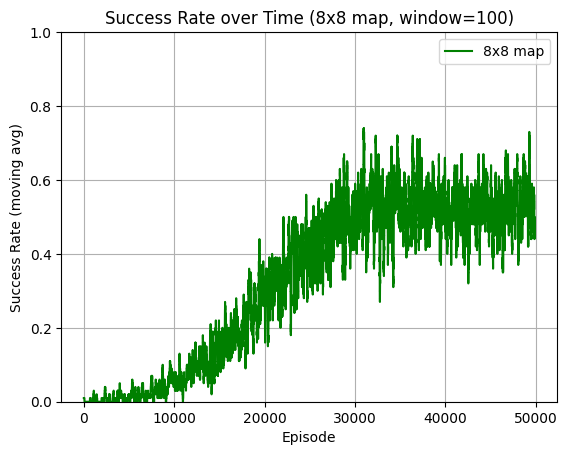

Final Success Rate (8x8 map): 0.47


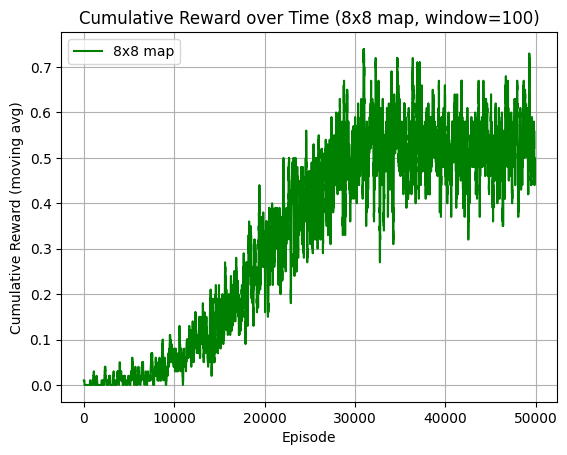

Final Cumulative Reward (8x8 map): 0.47


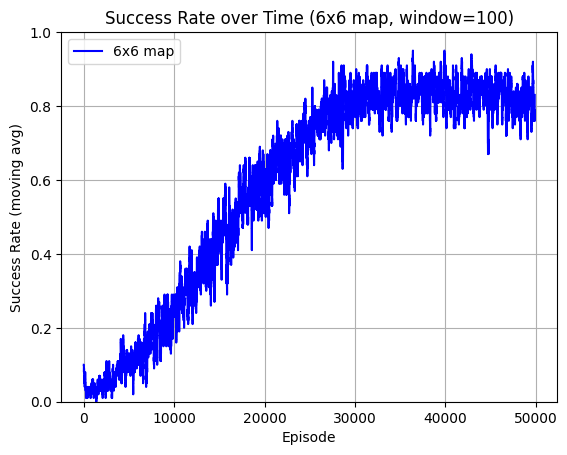

Final Success Rate (6x6 map): 0.83


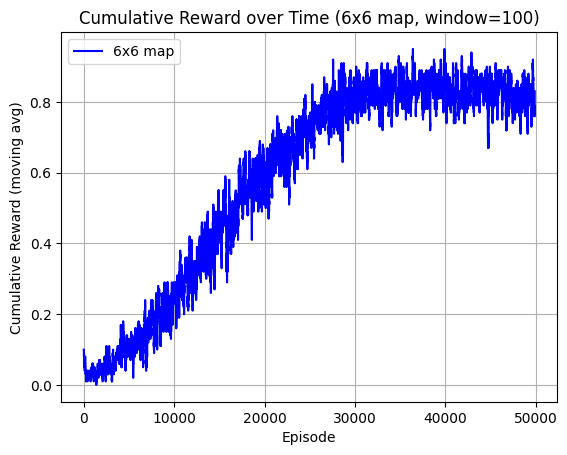

Final Cumulative Reward (6x6 map): 0.83


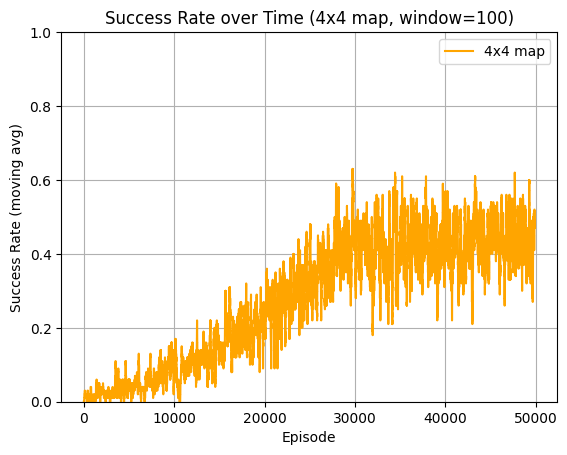

Final Success Rate (4x4 map): 0.47


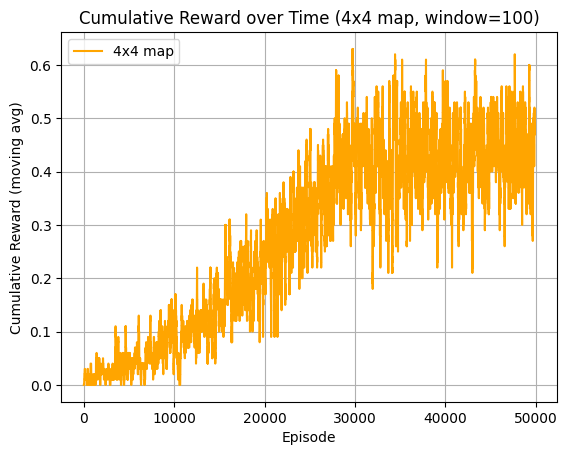

Final Cumulative Reward (4x4 map): 0.47

6x6 Map - Policy Comparison:
╒════════════╤════════════════╕
│ Policy     │ Success Rate   │
╞════════════╪════════════════╡
│ Q-Learning │ 58.33%         │
├────────────┼────────────────┤
│ Random     │ 0.10%          │
├────────────┼────────────────┤
│ Heuristic  │ 2.14%          │
╘════════════╧════════════════╛

8x8 Map - Policy Comparison:
╒════════════╤════════════════╕
│ Policy     │ Success Rate   │
╞════════════╪════════════════╡
│ Q-Learning │ 32.44%         │
├────────────┼────────────────┤
│ Random     │ 0.01%          │
├────────────┼────────────────┤
│ Heuristic  │ 0.25%          │
╘════════════╧════════════════╛

4x4 Map - Policy Comparison:
╒════════════╤════════════════╕
│ Policy     │ Success Rate   │
╞════════════╪════════════════╡
│ Q-Learning │ 27.45%         │
├────────────┼────────────────┤
│ Random     │ 0.18%          │
├────────────┼────────────────┤
│ Heuristic  │ 0.66%          │
╘════════════╧════════════════╛


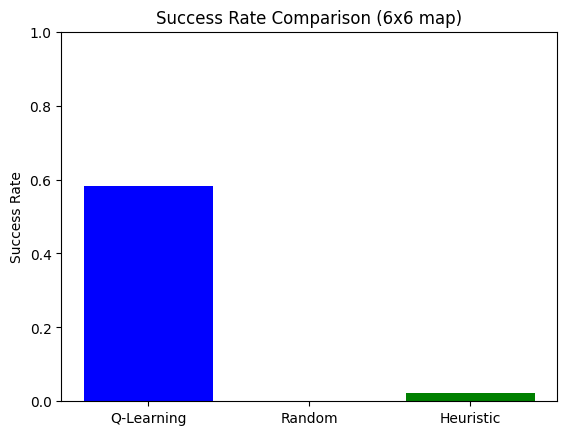

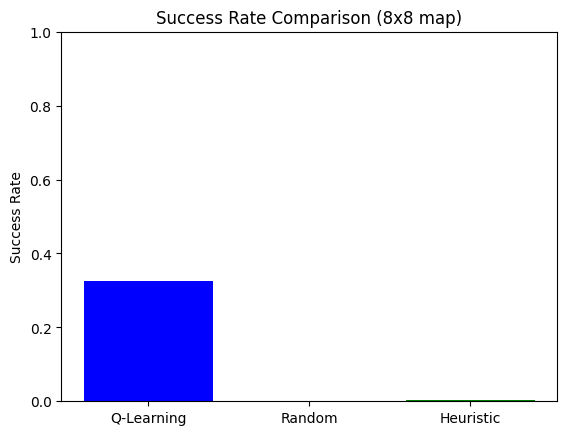

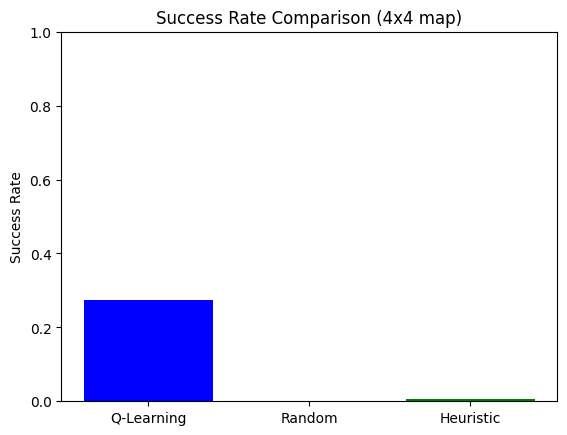

In [100]:
#success rate plot
def plot_success_rate(success_flags, window_size=100, label="6x6", plot=True):
    success_array = np.array(success_flags)
    success_rate = np.convolve(success_array, np.ones(window_size)/window_size, mode='valid')
    if not plot:
        return success_rate
    color = 'blue' if label == "6x6" else 'green' if label == "8x8" else 'orange'
    plt.plot(success_rate, color=color, label=f"{label} map")
    plt.xlabel('Episode')
    plt.ylabel('Success Rate (moving avg)')
    plt.title(f'Success Rate over Time ({label} map, window={window_size})')
    plt.ylim(0, 1)
    plt.grid()
    plt.legend()
    plt.show()
    
    print(f"Final Success Rate ({label} map): {success_rate[-1]:.2f}")





# cumulative reward plot
def plot_cumulative_rewards(rewards, window_size=100, label="6x6"):
    rewards_array = np.array(rewards)
    cumulative_rewards = np.convolve(rewards_array, np.ones(window_size)/window_size, mode='valid')

    color = 'blue' if label == "6x6" else 'green' if label == "8x8" else 'orange'
    plt.plot(cumulative_rewards, color=color, label=f"{label} map")
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward (moving avg)')
    plt.title(f'Cumulative Reward over Time ({label} map, window={window_size})')
    plt.grid()
    plt.legend()
    plt.show()
    
    print(f"Final Cumulative Reward ({label} map): {cumulative_rewards[-1]:.2f}")   


# Visualize the learned Q-table as a heatmap
def plot_q_table_heatmap(Q, title="Q-Table Heatmap"):
    plt.figure(figsize=(12, 8))
    sns.heatmap(Q, annot=False, cmap='viridis')
    plt.title(title)
    plt.xlabel('Actions')
    plt.ylabel('States')
    plt.show()
# 8x8 Frozen Lake results
plot_success_rate(success_flags, window_size=100, label="8x8")
plot_cumulative_rewards(rewards, window_size=100, label="8x8")
#plot_q_table_heatmap(Q_trained, title="Learned Q-Table Heatmap (8x8 Frozen Lake)")

# 6x6 Frozen Lake results
plot_success_rate(success_flags_6x6, window_size=100, label="6x6")
plot_cumulative_rewards(rewards_6x6, window_size=100, label="6x6")
#plot_q_table_heatmap(Q_trained_6x6, title="Learned Q-Table Heatmap (6x6 Frozen Lake)")

# 4x4 Frozen Lake results
plot_success_rate(success_flags_4x4, window_size=100, label="4x4")
plot_cumulative_rewards(rewards_4x4, window_size=100, label="4x4")
#plot_q_table_heatmap(Q_trained_4x4, title="Learned Q-Table Heatmap (4x4 Frozen Lake)")

# success rate table comparison between 6x6, 8x8, Random and Heuristic
def compare_success_rates(success_flags, success_flags_random, success_flags_heuristic, label="6x6", tablefmt='github'):
    success_rate_Q = np.mean(success_flags)
    success_rate_random = np.mean(success_flags_random)
    success_rate_heuristic = np.mean(success_flags_heuristic)
    data = {
        'Policy': ['Q-Learning', 'Random', 'Heuristic'],
        'Success Rate': [success_rate_Q, success_rate_random, success_rate_heuristic]
    }
    df = pd.DataFrame(data)
    df['Success Rate'] = df['Success Rate'].apply(lambda x: f"{x:.2%}")
    print(f"\n{label} Map - Policy Comparison:")
    print(tabulate(df, headers='keys', tablefmt=tablefmt, showindex=False))


def plot_success_comparison(success_flags_Q, success_flags_random, success_flags_heuristic, label="6x6", policies=['Q-Learning', 'Random', 'Heuristic']):
    success_rate_Q = np.mean(success_flags_Q)
    success_rate_random = np.mean(success_flags_random)
    success_rate_heuristic = np.mean(success_flags_heuristic)
    success_rates = [success_rate_Q, success_rate_random, success_rate_heuristic]
    colors = ['blue', 'red', 'green']
    plt.bar(policies, success_rates, color=colors)
    plt.ylim(0, 1)
    plt.ylabel('Success Rate')
    plt.title(f'Success Rate Comparison ({label} map)')
    plt.show()

compare_success_rates(success_flags_6x6,success_flags_random_6x6, success_flags_heuristic_6x6, label="6x6", tablefmt='fancy_grid')
compare_success_rates(success_flags,success_flags_random_8x8, success_flags_heuristic_8x8, label="8x8", tablefmt='fancy_grid')
compare_success_rates(success_flags_4x4,success_flags_random_4x4, success_flags_heuristic_4x4, label="4x4", tablefmt='fancy_grid')

plot_success_comparison(success_flags_6x6,success_flags_random_6x6, success_flags_heuristic_6x6, label="6x6")
plot_success_comparison(success_flags,success_flags_random_8x8, success_flags_heuristic_8x8, label="8x8")
plot_success_comparison(success_flags_4x4,success_flags_random_4x4, success_flags_heuristic_4x4, label="4x4")

<a class="anchor" id="optimization"></a>
# Optimization

In [135]:
# reliable greedy evaluator
def reliable_greedy_evaluator(env: gym.Env, Q: np.ndarray, num_episodes: int = 1000):
    success_flags = []
    steps_ = []
    for _ in range(num_episodes):
        state, info = env.reset()
        done = False
        steps = 0
        while not done:
            action = np.argmax(Q[state])  # Choose the best action based on Q-values
            next_state, reward, done, truncated, info = env.step(action)
            state = next_state
            steps += 1
        success_flags.append(1 if done and reward > 0 else 0)
        steps_.append(steps)
            
    return success_flags, steps_


greedy_success_flags_8x8, greedy_steps_8x8 = reliable_greedy_evaluator(env, Q_trained, num_episodes=500)
print(f"Greedy Policy Success Rate (8x8): {np.mean(greedy_success_flags_8x8):.2%}, Average Steps: {np.mean(greedy_steps_8x8):.2f}")



Greedy Policy Success Rate (8x8): 88.20%, Average Steps: 118.49


In [116]:
# try other epsilon decay function
def epsilon_exponential_decay(t, epsilon_initial, epsilon_min, decay):
    '''Exponential decay of epsilon.'''
    return max(epsilon_min,epsilon_initial*(decay**t))

def epsilon_linear_decay(t, total_episodes, epsilon_initial, epsilon_min):
    '''Linear decay of epsilon over 80% of training'''
    stop = int(0.8*total_episodes)
    if t > stop:
        return epsilon_min
    return epsilon_initial -(epsilon_initial-epsilon_min)*(t/stop)

Q_trained_exponential, rewards_exponential, success_flags_exponential = q_learning_training(env, num_episodes=50000, alpha=0.5, gamma=0.99, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.9999, visualize=False, epsilon_scheduling_type='exponential')
#Q_trained_linear, rewards_linear, success_flags_linear = q_learning_training(env, num_episodes=50000, alpha=0.5, gamma=0.99, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.9999, visualize=False, epsilon_scheduling_type='linear')

Episode 50000/50000, Total Reward: 0, Epsilon: 0.0500


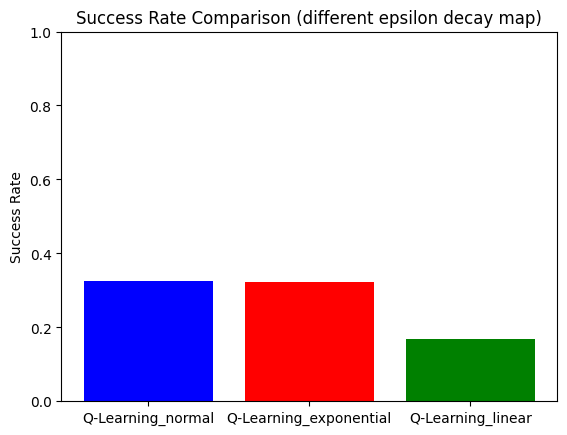

Final Success Rate (normal epsilon decay): 32.44%
Final Success Rate (exponential epsilon decay): 32.13%
Final Success Rate (linear epsilon decay): 16.70%
Episode 0: Failure in 193 steps
Episode 100: Success in 112 steps
Episode 200: Success in 136 steps
Episode 300: Success in 92 steps
Episode 400: Success in 88 steps
Episode 0: Success in 402 steps
Episode 100: Success in 154 steps
Episode 200: Success in 174 steps
Episode 300: Success in 52 steps
Episode 400: Success in 192 steps
Greedy Policy Success Rate (exponential epsilon decay): 93.20%, Average Steps: 137.14
Greedy Policy Success Rate (linear epsilon decay): 54.20%, Average Steps: 117.79


In [117]:
# compare results of different epsilon decay functions
plot_success_comparison(success_flags,success_flags_exponential, success_flags_linear, label="different epsilon decay", policies=['Q-Learning_normal', 'Q-Learning_exponential', 'Q-Learning_linear'])
print(f"Final Success Rate (normal epsilon decay): {np.mean(success_flags):.2%}")
print(f"Final Success Rate (exponential epsilon decay): {np.mean(success_flags_exponential):.2%}")
print(f"Final Success Rate (linear epsilon decay): {np.mean(success_flags_linear):.2%}")


greedy_success_flags_linear, greedy_steps_linear = reliable_greedy_evaluator(env, Q_trained_linear, num_episodes=500)
greedy_success_flags_exponential, greedy_steps_exponential = reliable_greedy_evaluator(env, Q_trained_exponential, num_episodes=500)

print(f"Greedy Policy Success Rate (exponential epsilon decay): {np.mean(greedy_success_flags_exponential):.2%}, Average Steps: {np.mean(greedy_steps_exponential):.2f}")
print(f"Greedy Policy Success Rate (linear epsilon decay): {np.mean(greedy_success_flags_linear):.2%}, Average Steps: {np.mean(greedy_steps_linear):.2f}")

Episode 50000/50000, Total Reward: 0, Epsilon: 0.0500
Alpha: 0.9, Gamma: 0.99, Success Rate: 0.00%


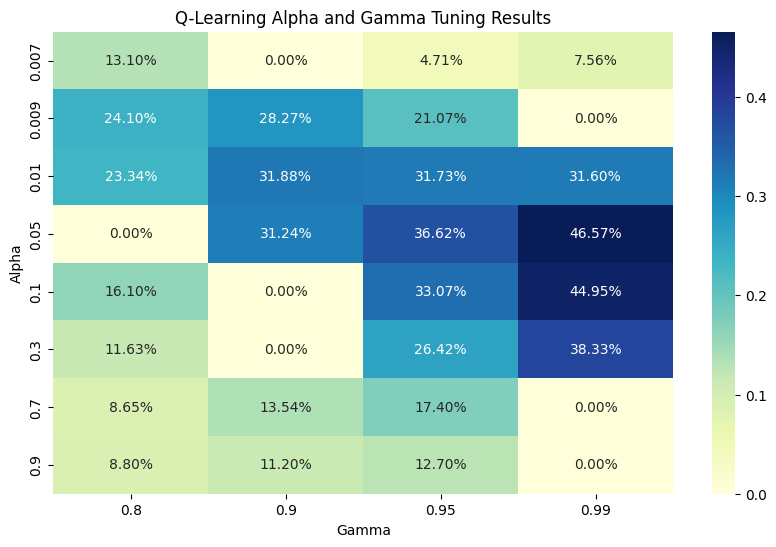

In [130]:
# Learning Rate and Discount Factor Tuning
def q_learning_alpha_gamma_tuning(env: gym.Env, alpha_values: list, gamma_values: list, num_episodes: int = 10000):
    results = []
    for alpha in alpha_values:
        for gamma in gamma_values:
            Q, rewards, success_flags = q_learning_training(env, num_episodes=num_episodes, alpha=alpha, gamma=gamma, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.9999, visualize=False)
            success_rate = np.mean(success_flags)
            results.append((alpha, gamma, success_rate))
            print(f"Alpha: {alpha}, Gamma: {gamma}, Success Rate: {success_rate:.2%}")
    df_results = pd.DataFrame(results, columns=['Alpha', 'Gamma', 'Success Rate'])
    return df_results

# heatmap of tuning results
def plot_tuning_heatmap(df_results):
    pivot_table = df_results.pivot(index='Alpha', columns='Gamma', values='Success Rate')
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".2%", cmap='YlGnBu')
    plt.title('Q-Learning Alpha and Gamma Tuning Results')
    plt.xlabel('Gamma')
    plt.ylabel('Alpha')
    plt.show()


alpha_values = [
    0.007, 0.009, 0.01, 0.05, 0.1, 0.3, 0.7, 0.9]
gamma_values = [0.8, 0.9, 0.95, 0.99]
tuning_results = q_learning_alpha_gamma_tuning(env, alpha_values, gamma_values, num_episodes=50000)
plot_tuning_heatmap(tuning_results)

In [144]:
# reward shaping with everystep penalty -0.01 , hole -1, goal +1
def q_learning_training_with_reward_shaping(env: gym.Env, num_episodes: int, alpha: float, gamma: float, epsilon: float, epsilon_min: float, epsilon_decay: float, visualize: bool = False, epsilon_scheduling_type: str = 'normal', step_penalty: float = -0.01, hole_penalty: float = -10.0, goal_reward: float = 1.0):
    '''Q-learning training with reward shaping.'''
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))
    epsilon_initial = epsilon
    
    # tracking variables
    rewards = [] # total rewards per episode
    success_flags = [] # 1 if goal reached, else 0

    for episode in range(num_episodes):
        state, info = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = epsilon_greedy_policy(Q, state, epsilon) # ε-greedy action selection
            # Take a step in the environment
            next_state, raw_reward, done, truncated, info = env.step(action)
            # Reward shaping
            if done and raw_reward > 0:
                reward = goal_reward  # Goal reached
            elif done and raw_reward == 0:
                reward = hole_penalty  # Fell into a hole
            else:
                reward = step_penalty  # Every step penalty
            # Q-value update
            q_update(Q, state, action,reward, next_state, alpha, gamma, done)
            state = next_state
            total_reward += raw_reward
            # Visualization
            if visualize:
                env.render()
                img = env.render()
                plt.imshow(img) 
                plt.axis('off')
                clear_output(wait=True)
                display(plt.gcf())
                if done:
                    clear_output(wait=False)
        # record results
        rewards.append(total_reward)
        success_flags.append(1 if done and raw_reward > 0 else 0)

        # Decay epsilon
        if epsilon_scheduling_type == 'normal':
            epsilon = epsilon_decay_normal(epsilon, epsilon_min, epsilon_decay)
        
        elif epsilon_scheduling_type == 'linear':
            epsilon = epsilon_linear_decay(episode, num_episodes, epsilon_initial, epsilon_min)
        
        elif epsilon_scheduling_type == 'exponential':
            epsilon = epsilon_exponential_decay(episode, epsilon_initial, epsilon_min, epsilon_decay)


        # Progress printing
        if (episode + 1) % 1000 == 0:
            clear_output(wait=True)
            print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.4f}")

    return Q, rewards, success_flags




In [ ]:
# compute Q-learning with reward shaping and compare results without reward shaping
Q_trained_shaped, rewards_shaped, success_flags_shaped = q_learning_training_with_reward_shaping(env, num_episodes=50000, alpha=0.05, gamma=0.99, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.9999, visualize=False, epsilon_scheduling_type='normal')
Q_trained, rewards, success_flags = q_learning_training(env, num_episodes=50000, alpha=0.05, gamma=0.99, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.9999, visualize=False, epsilon_scheduling_type='normal')
#success rate
print(f"Final Success Rate (without reward shaping): {np.mean(success_flags):.2%}")
print(f"Final Success Rate (with reward shaping): {np.mean(success_flags_shaped):.2%}")
# greedy evaluation
greedy_success_flags_no_shaping, greedy_steps_no_shaping = reliable_greedy_evaluator(env, Q_trained, num_episodes=500)
greedy_success_flags_with_shaping, greedy_steps_with_shaping = reliable_greedy_evaluator(env, Q_trained_shaped, num_episodes=500)
print(f"Greedy Policy Success Rate (without reward shaping): {np.mean(greedy_success_flags_no_shaping):.2%}, Average Steps: {np.mean(greedy_steps_no_shaping):.2f}")
print(f"Greedy Policy Success Rate (with reward shaping): {np.mean(greedy_success_flags_with_shaping):.2%}, Average Steps: {np.mean(greedy_steps_with_shaping):.2f}")


Episode 50000/50000, Total Reward: 0, Epsilon: 0.0500
Final Success Rate (without reward shaping): 46.27%
Final Success Rate (with reward shaping): 53.98%
Greedy Policy Success Rate (without reward shaping): 84.00%, Average Steps: 83.51
Greedy Policy Success Rate (with reward shaping): 100.00%, Average Steps: 118.17


In [ ]:
# max episode step

In [148]:
# build sweep function for hyperparameter tuning
def hyperparameter_sweep(env: gym.Env, alpha_values: list, gamma_values: list, num_episodes: int = 10000, epsilon_scheduling_types: list = ['normal', 'linear', 'exponential'], step_penalties: list = [-0.01, -0.1], hole_penalties: list = [-1, -10.0, -100.0], goal_rewards: list = [1.0, 10.0, 100.0]):
    results = []
    for alpha, gamma, epsilon_scheduling_type, step_penalty, hole_penalty, goal_reward in itertools.product(alpha_values, gamma_values, epsilon_scheduling_types, step_penalties, hole_penalties, goal_rewards):
        Q, rewards, success_flags = q_learning_training_with_reward_shaping(env_4x4, num_episodes=num_episodes, alpha=alpha, gamma=gamma, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.9999, visualize=False, epsilon_scheduling_type=epsilon_scheduling_type, step_penalty=step_penalty, hole_penalty=hole_penalty, goal_reward=goal_reward)
        success_rate = np.mean(success_flags)
        results.append((alpha, gamma, epsilon_scheduling_type, step_penalty, hole_penalty, goal_reward, success_rate))
        print(f"Alpha: {alpha}, Gamma: {gamma}, Epsilon Decay: {epsilon_scheduling_type}, Step Penalty: {step_penalty}, Hole Penalty: {hole_penalty}, Goal Reward: {goal_reward}, Success Rate: {success_rate:.2%}")
    df_results = pd.DataFrame(results, columns=['Alpha', 'Gamma', 'Epsilon Decay', 'Step Penalty', 'Hole Penalty', 'Goal Reward', 'Success Rate'])
    return df_results
alpha_values = [0.01, 0.05, 0.1]
gamma_values = [0.95, 0.99]
sweep_results = hyperparameter_sweep(env, alpha_values, gamma_values, num_episodes=20000)
# display top 10 results    
top_10_results = sweep_results.nlargest(10, 'Success Rate')
print("\nTop 10 Hyperparameter Configurations:")
print(tabulate(top_10_results, headers='keys', tablefmt='fancy_grid', showindex=False))



Episode 20000/20000, Total Reward: 0, Epsilon: 0.1353
Alpha: 0.1, Gamma: 0.99, Epsilon Decay: exponential, Step Penalty: -0.1, Hole Penalty: -100.0, Goal Reward: 100.0, Success Rate: 13.05%

Top 10 Hyperparameter Configurations:
╒═════════╤═════════╤═════════════════╤════════════════╤════════════════╤═══════════════╤════════════════╕
│   Alpha │   Gamma │ Epsilon Decay   │   Step Penalty │   Hole Penalty │   Goal Reward │   Success Rate │
╞═════════╪═════════╪═════════════════╪════════════════╪════════════════╪═══════════════╪════════════════╡
│    0.01 │    0.99 │ linear          │          -0.01 │            -10 │           100 │        0.2141  │
├─────────┼─────────┼─────────────────┼────────────────┼────────────────┼───────────────┼────────────────┤
│    0.01 │    0.95 │ linear          │          -0.1  │            -10 │            10 │        0.21165 │
├─────────┼─────────┼─────────────────┼────────────────┼────────────────┼───────────────┼────────────────┤
│    0.05 │    0.95 │ 

In [149]:
# run top 10 configurations on 8x8 map
top_configs = top_10_results[['Alpha', 'Gamma', 'Epsilon Decay', 'Step Penalty', 'Hole Penalty', 'Goal Reward']].values
result_dict = {}
for config in top_configs:
    Q, rewards, success_flags = q_learning_training_with_reward_shaping(env, num_episodes=50000, alpha=config[0], gamma=config[1], epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.9999, visualize=False, epsilon_scheduling_type=config[2], step_penalty=config[3], hole_penalty=config[4], goal_reward=config[5])
    success_rate = np.mean(success_flags)
    result_dict[tuple(config)] = success_rate


for config, success_rate in result_dict.items():
    print(f"Config: Alpha={config[0]}, Gamma={config[1]}, Epsilon Decay={config[2]}, Step Penalty={config[3]}, Hole Penalty={config[4]}, Goal Reward={config[5]} => Success Rate: {success_rate:.2%}")

Episode 50000/50000, Total Reward: 0, Epsilon: 0.0500
Config: Alpha=0.01, Gamma=0.99, Epsilon Decay=linear, Step Penalty=-0.01, Hole Penalty=-10.0, Goal Reward=100.0 => Success Rate: 25.94%
Config: Alpha=0.01, Gamma=0.95, Epsilon Decay=linear, Step Penalty=-0.1, Hole Penalty=-10.0, Goal Reward=10.0 => Success Rate: 24.13%
Config: Alpha=0.05, Gamma=0.95, Epsilon Decay=linear, Step Penalty=-0.1, Hole Penalty=-10.0, Goal Reward=10.0 => Success Rate: 23.94%
Config: Alpha=0.01, Gamma=0.95, Epsilon Decay=linear, Step Penalty=-0.01, Hole Penalty=-10.0, Goal Reward=10.0 => Success Rate: 25.45%
Config: Alpha=0.05, Gamma=0.99, Epsilon Decay=linear, Step Penalty=-0.1, Hole Penalty=-10.0, Goal Reward=100.0 => Success Rate: 24.73%
Config: Alpha=0.01, Gamma=0.99, Epsilon Decay=linear, Step Penalty=-0.1, Hole Penalty=-10.0, Goal Reward=10.0 => Success Rate: 24.89%
Config: Alpha=0.01, Gamma=0.95, Epsilon Decay=linear, Step Penalty=-0.1, Hole Penalty=-10.0, Goal Reward=1.0 => Success Rate: 26.23%
Confi

- maybe add a reward system to give the agent a tiny negative reward per step (-0.01) that encourages shorter paths